In [107]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
adult_train = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
adult_train.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
adult_train = adult_train.replace({' ?':np.nan}).dropna()
adult_train = adult_train.reset_index(drop=True)
# df_train = adult_train[['education', 'occupation', 'marital-status', 'race', 'sex']]
df_train = adult_train[['education', 'occupation', 'race', 'sex']]
df_train_male = pd.get_dummies(df_train, drop_first=True)
df_train_female = df_train_male.copy()
df_train_female['sex_ Male'] = df_train_female['sex_ Male'].apply(lambda x : x^1)
train_target = pd.get_dummies(adult_train['target'], drop_first=True)

df_train_male.head()

,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,...,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0


In [4]:
model = RandomForestClassifier(random_state=0).fit(df_train_male.values, train_target.values.ravel())

prob = np.amax(model.predict_proba(df_train_male), axis=1)
prob_flip = np.amax(model.predict_proba(df_train_female), axis=1)

train_flip = df_train.copy()
male_index = train_flip.loc[train_flip['sex']==' Male'].index
female_index = train_flip.loc[train_flip['sex']==' Female'].index

In [5]:
diff = np.mean(prob[male_index]) - np.mean(prob[female_index])
# diff_flip = np.mean(prob_flip[male_index]) - np.mean(prob_flip[female_index])
diff_flip = np.mean(prob_flip[female_index]) - np.mean(prob_flip[male_index])
avg_effect = diff_flip - diff
print('average effect: ', avg_effect)

average effect:  0.02438461947758641


In [6]:
train_flip['effect'] = prob_flip - prob
train_flip['deviation'] = train_flip['effect'] - avg_effect
train_flip.sort_values('deviation', ascending=False).head()

,education,occupation,race,sex,effect,deviation
20250,Prof-school,Prof-specialty,Black,Male,0.496255,0.471871
29410,Prof-school,Prof-specialty,Black,Male,0.496255,0.471871
19944,Prof-school,Prof-specialty,Black,Male,0.496255,0.471871
5907,Prof-school,Prof-specialty,Black,Male,0.496255,0.471871
4069,Prof-school,Prof-specialty,Black,Male,0.496255,0.471871


In [7]:
import pysubgroup as ps

target = ps.NumericTarget('deviation')
searchSpace = ps.create_nominal_selectors(train_flip.drop('effect', axis=1), ignore=['deviation', "sex"])
# searchSpace = ps.create_selectors(train_flip.drop('effect', axis=1), ignore=['deviation', "sex"])
task = ps.SubgroupDiscoveryTask (train_flip.drop('effect', axis=1), target, searchSpace, depth=4, qf=ps.StandardQF_numeric(1))
result = ps.BeamSearch().execute(task)
for (q, sg) in result:
    print (str(q) + ":\t" + str(sg.subgroup_description))

373.29547658951475:	occupation= Craft-repair
354.53694418152173:	race= White AND occupation= Craft-repair
191.21221531071328:	education= HS-grad AND occupation= Craft-repair
189.13674944767845:	race= White AND education= HS-grad AND occupation= Craft-repair
183.94702579219427:	race= White AND education= HS-grad
182.11464048602028:	race= White
157.26306398480492:	race= White AND education= Bachelors
150.48819590601116:	race= White AND education= Some-college
133.13304116101583:	education= HS-grad
132.41345165961414:	education= Bachelors


In [8]:
df = ps.resultsAsDataFrame(train_flip, result, statistics_to_show=ps.all_statistics_numeric)
df

,quality,subgroup,size_sg,size_dataset,mean_sg,mean_dataset,std_sg,std_dataset,median_sg,median_dataset,max_sg,max_dataset,min_sg,min_dataset,mean_lift,median_lift
0,373.295477,occupation= Craft-repair,4030.0,30162.0,0.111534,0.018905,0.145536,0.18226,0.142432,0.028351,0.444663,0.471871,-0.493432,-0.52064,5.899664,5.023951
1,354.536944,race= White AND occupation= Craft-repair,3644.0,30162.0,0.116199,0.018905,0.143607,0.18226,0.142432,0.028351,0.433778,0.471871,-0.482547,-0.52064,6.146379,5.023951
2,191.212215,education= HS-grad AND occupation= Craft-repair,1903.0,30162.0,0.119385,0.018905,0.072879,0.18226,0.142432,0.028351,0.142432,0.471871,-0.191202,-0.52064,6.314904,5.023951
3,189.136749,race= White AND education= HS-grad AND occupat...,1731.0,30162.0,0.128170,0.018905,0.067492,0.18226,0.142432,0.028351,0.142432,0.471871,-0.191202,-0.52064,6.779596,5.023951
4,183.947026,race= White AND education= HS-grad,8401.0,30162.0,0.040801,0.018905,0.141295,0.18226,0.074373,0.028351,0.243555,0.471871,-0.292324,-0.52064,2.158192,2.623322
5,182.114640,race= White,25933.0,30162.0,0.025928,0.018905,0.182809,0.18226,0.041492,0.028351,0.433778,0.471871,-0.482547,-0.52064,1.371459,1.463543
6,157.263064,race= White AND education= Bachelors,4448.0,30162.0,0.054261,0.018905,0.201862,0.18226,0.036562,0.028351,0.410382,0.471871,-0.459152,-0.52064,2.870168,1.289635
7,150.488196,race= White AND education= Some-college,5705.0,30162.0,0.045284,0.018905,0.200432,0.18226,0.092755,0.028351,0.300563,0.471871,-0.349332,-0.52064,2.395293,3.271701
8,133.133041,education= HS-grad,9840.0,30162.0,0.032435,0.018905,0.143203,0.18226,0.059665,0.028351,0.458949,0.471871,-0.507718,-0.52064,1.715664,2.104541
9,132.413452,education= Bachelors,5044.0,30162.0,0.045157,0.018905,0.207711,0.18226,0.027609,0.028351,0.433949,0.471871,-0.482718,-0.52064,2.388595,0.973836


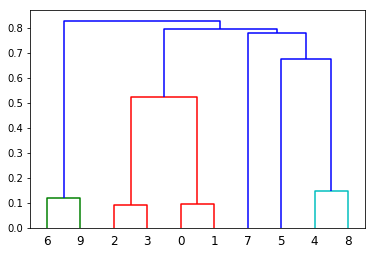

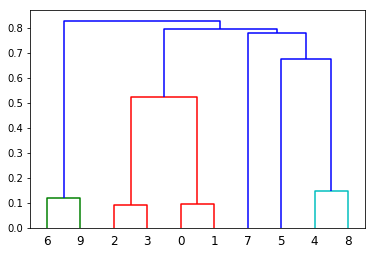

In [9]:
ps.similarity_dendrogram(result, train_flip)


In [10]:
ps.similarity_sgs(result, train_flip)

,0,1,2,3,4,5,6,7,8,9
0,1,0.904218,0.472208,0.429529,0.161776,0.138455,0.0236658,0.0852843,0.159021,0.0248475
1,0.904218,1,0.453616,0.475027,0.16783,0.140516,0.0248227,0.0891193,0.147282,0.0230805
2,0.472208,0.453616,1,0.909616,0.201913,0.0663091,0,0,0.193394,0
3,0.429529,0.475027,0.909616,1,0.206047,0.0667489,0,0,0.175915,0
4,0.161776,0.16783,0.201913,0.206047,1,0.32395,0,0,0.85376,0
5,0.138455,0.140516,0.0663091,0.0667489,0.32395,1,0.171519,0.21999,0.306919,0.167666
6,0.0236658,0.0248227,0,0,0,0.171519,1,0,0,0.88184
7,0.0852843,0.0891193,0,0,0,0.21999,0,1,0,0
8,0.159021,0.147282,0.193394,0.175915,0.85376,0.306919,0,0,1,0
9,0.0248475,0.0230805,0,0,0,0.167666,0.88184,0,0,1


In [11]:
np.random.seed(0)
data = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
data_shuffle = data.copy()
data_shuffle['age'] = np.random.permutation(data_shuffle['age'].values)
data_shuffle.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,27,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,27,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,25,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,46,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,45,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
cate_features = ['education', 'occupation', 'marital-status', 'race', 'sex']
num_features = ['age', 'hours-per-week']
target = 'target'
data_cate = data[cate_features]
data_num = data[num_features]
shuffle_num = data_shuffle[num_features]

X = pd.get_dummies(data_cate, drop_first=True).join(data_num, how='inner')
shuffle_X = pd.get_dummies(data_cate, drop_first=True).join(shuffle_num, how='inner')
y = data[target]

rf_model = RandomForestClassifier(random_state=0).fit(X, y)

In [13]:
prob = np.amax(rf_model.predict_proba(X), axis=1)
shuff_prob = np.amax(rf_model.predict_proba(shuffle_X), axis=1)
avg_effect = np.mean(shuff_prob) - np.mean(prob)

In [89]:
data_shuffle['age_change'] = data_shuffle['age'] - data['age']
data_shuffle['deviation'] = (shuff_prob - prob) - avg_effect
data_shuffle.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,age_change,deviation
0,27,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,-12,0.020239
1,27,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,-23,0.351667
2,25,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,-13,0.020239
3,46,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,-7,-0.279761
4,45,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,17,0.120239


In [106]:
grouped_data = data_shuffle.groupby(data_shuffle['age_change'])
df_age = grouped_data[['deviation']].mean()
df_effect = pd.DataFrame(df_age.index)
df_effect['mean_effect'] = df_age['deviation'].values
pear_corr = np.corrcoef(df_effect['age_change'].values, df_effect['mean_effect'].values)[0, 1]
print('pearson correlation: ', pear_corr)
df_effect.head()

pearson correlation:  -0.5997309879251117


,age_change,mean_effect
0,-73,0.070239
1,-72,0.020239
2,-71,0.020239
3,-68,0.053572
4,-67,0.053572


Text(10,0.1,'pearson correlation: -0.6')

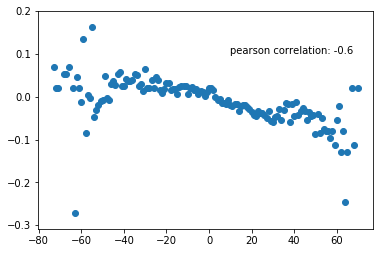

In [132]:
fig, ax = plt.subplots()
ax.scatter(df_effect['age_change'], df_effect['mean_effect'])
ax.annotate('pearson correlation: {0}'.format(round(pear_corr, 2)), (10, 0.1))
# plt.scatter(x=df_effect['age_change'], y=df_effect['mean_effect'])

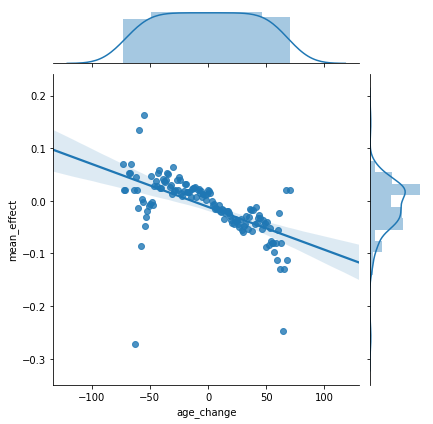

In [125]:
import seaborn as sns
sns.jointplot(x=df_effect['age_change'], y=df_effect['mean_effect'], data=df_effect, kind="reg")

In [15]:
target = ps.NumericTarget('deviation')
search_space = ps.create_numeric_selectors(data_shuffle, ignore=['age', 'target', 'deviation'])
task = ps.SubgroupDiscoveryTask(data_shuffle, target, search_space, qf=ps.StandardQF_numeric(1))
result = ps.BeamSearch().execute(task)


In [16]:
for (q, sg) in result:
    print('{0}:\t {1}'.format(q, sg.subgroup_description))

292.6642825154477:	 hours-per-week: [40:41[
274.86340702906006:	 capital-loss: [0:155[ AND hours-per-week: [40:41[
255.2218573446231:	 hours-per-week: [40:41[ AND capital-gain: [0:114[
237.42098185822226:	 capital-loss: [0:155[ AND hours-per-week: [40:41[ AND capital-gain: [0:114[
197.6482594368085:	 education-num: [9:10[
193.07310925134578:	 education-num: [9:10[ AND hours-per-week: [40:41[
183.9313327588628:	 capital-loss: [0:155[ AND education-num: [9:10[
183.5168335966879:	 age_change<-16 AND hours-per-week: [40:41[
182.67839163192832:	 capital-loss: [0:155[ AND education-num: [9:10[ AND hours-per-week: [40:41[
181.64285100894165:	 age_change<-16 AND capital-gain: [0:114[ AND capital-loss: [0:155[


In [17]:
ps.as_df(data_shuffle, result, statistics_to_show=ps.all_statistics_numeric)

,quality,subgroup,size_sg,size_dataset,mean_sg,mean_dataset,std_sg,std_dataset,median_sg,median_dataset,max_sg,max_dataset,min_sg,min_dataset,mean_lift,median_lift
0,292.664283,hours-per-week: [40:41[,15217.0,32561.0,0.019233,1.059078e-16,0.170134,0.167511,0.020239,0.020239,0.520239,0.520239,-0.479761,-0.479761,1.815987e+14,1.0
1,274.863407,capital-loss: [0:155[ AND hours-per-week: [40:41[,14559.0,32561.0,0.018879,1.059078e-16,0.169151,0.167511,0.020239,0.020239,0.520239,0.520239,-0.479761,-0.479761,1.782615e+14,1.0
2,255.221857,hours-per-week: [40:41[ AND capital-gain: [0:114[,14096.0,32561.0,0.018106,1.059078e-16,0.166636,0.167511,0.020239,0.020239,0.520239,0.520239,-0.479761,-0.479761,1.709598e+14,1.0
3,237.420982,capital-loss: [0:155[ AND hours-per-week: [40:...,13438.0,32561.0,0.017668,1.059078e-16,0.165371,0.167511,0.020239,0.020239,0.520239,0.520239,-0.479761,-0.479761,1.668232e+14,1.0
4,197.648259,education-num: [9:10[,10501.0,32561.0,0.018822,1.059078e-16,0.163057,0.167511,0.020239,0.020239,0.520239,0.520239,-0.479761,-0.479761,1.777192e+14,1.0
5,193.073109,education-num: [9:10[ AND hours-per-week: [40:41[,5524.0,32561.0,0.034952,1.059078e-16,0.166250,0.167511,0.020239,0.020239,0.520239,0.520239,-0.479761,-0.479761,3.300199e+14,1.0
6,183.931333,capital-loss: [0:155[ AND education-num: [9:10[,10098.0,32561.0,0.018215,1.059078e-16,0.161987,0.167511,0.020239,0.020239,0.520239,0.520239,-0.479761,-0.479761,1.719857e+14,1.0
7,183.516834,age_change<-16 AND hours-per-week: [40:41[,2919.0,32561.0,0.062870,1.059078e-16,0.192244,0.167511,0.020239,0.020239,0.520239,0.520239,-0.479761,-0.479761,5.936273e+14,1.0
8,182.678392,capital-loss: [0:155[ AND education-num: [9:10...,5328.0,32561.0,0.034286,1.059078e-16,0.165647,0.167511,0.020239,0.020239,0.520239,0.520239,-0.479761,-0.479761,3.237390e+14,1.0
9,181.642851,age_change<-16 AND capital-gain: [0:114[ AND c...,5350.0,32561.0,0.033952,1.059078e-16,0.185067,0.167511,0.020239,0.020239,0.520239,0.520239,-0.479761,-0.479761,3.205801e+14,1.0
